<a href="https://colab.research.google.com/github/Flyingzaptop/Hacking/blob/master/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%20%D0%BA%D0%BE%D0%BC%D0%BF%20%D0%B7%D1%96%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision import transforms

# Завантажуємо зображення
img = read_image("/content/humans.jpg")
bg = read_image("/content/forest.jpg")

# Змінюємо розмір
img = transforms.Resize((1024, 1024))(img)
bg = transforms.Resize((1024, 1024))(bg)
# Завантажуємо натреновану модель
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# Завантажуємо препроцесор для моделі(без зміни розмірів)
preprocess = weights.transforms(resize_size=None)

# Обробляєио забраження та змінюємо розмірність до [1, 3, width, height]
batch1 = preprocess(img)
batch2 = preprocess(bg)
batch1 = batch1.unsqueeze(0)
batch2 = batch2.unsqueeze(0)

# Робимо прогноз
with torch.no_grad():
  prediction1 = model(batch1)["out"]
  prediction2 = model(batch2)["out"]

masks1 = prediction1.argmax(dim=1)
mask1 = masks1[0]
masks2 = prediction2.argmax(dim=1)
mask2 = masks2[0]

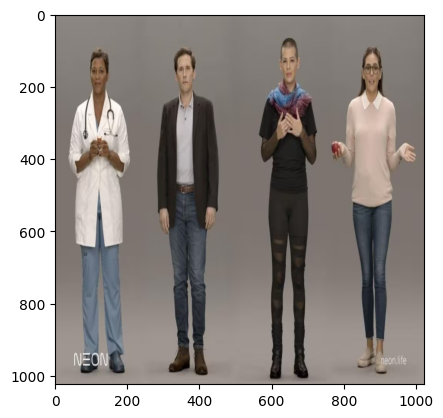

In [39]:
import matplotlib.pyplot as plt

# Візуалізація
plt.imshow(img.permute(1, 2, 0))

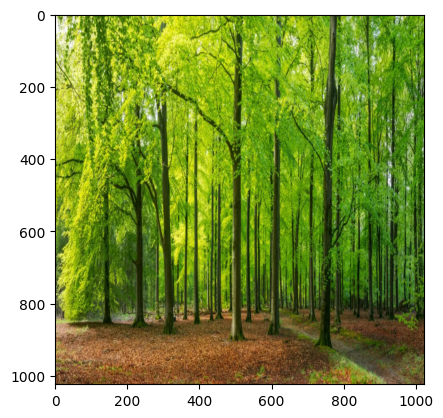

In [40]:
plt.imshow(bg.permute(1, 2, 0))

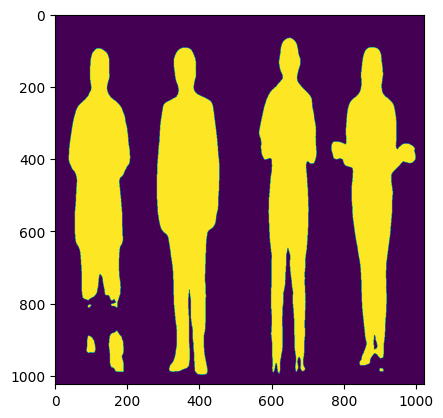

In [41]:
plt.imshow(mask1)

In [42]:
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

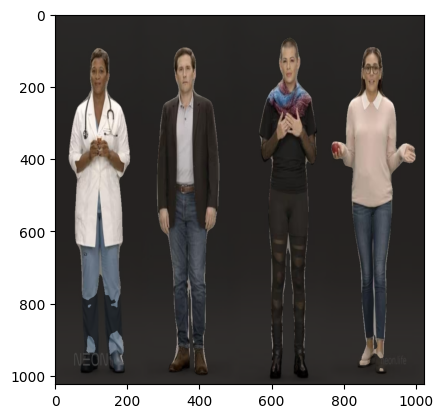

In [43]:
from torchvision.utils import draw_segmentation_masks

cat_mask = mask1 == class_to_idx['person']
background_mask = ~cat_mask
masked_img = draw_segmentation_masks(img, background_mask, alpha=0.7)

plt.imshow(masked_img.permute(1, 2, 0))

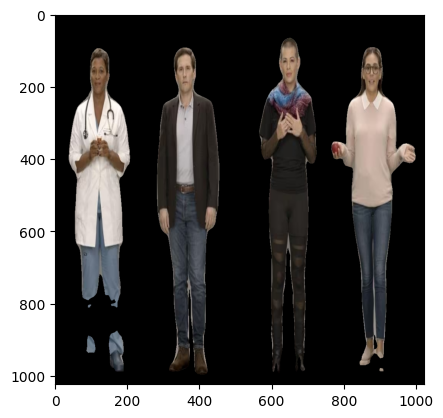

In [44]:
masked_img = img.clone() # копіювання
masked_img = masked_img.to(int) # зміна типу даних на int

yellow_pixel = torch.tensor([0, 0, 0])
masked_img[:, background_mask] = yellow_pixel.view(-1, 1)

plt.imshow(masked_img.permute(1, 2, 0))

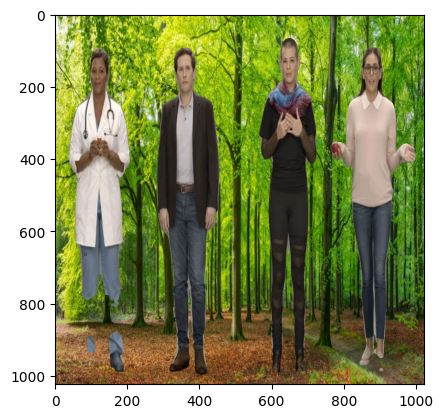

In [45]:
final_img = torch.where(cat_mask.unsqueeze(0), masked_img, bg)
plt.imshow(final_img.permute(1, 2, 0))